# Constrained Least Squares problems

Here, we use the theory developed in the previous notebook to combat constrained problems.  Although the previous notebook was specifically focused on unconstrained least squares, the general theory applies to constrained problems so we check if the CountSketch still works in this setting.

In [1]:
import numpy as np
import scipy as sp
from sklearn.datasets import make_regression
from scipy.optimize import minimize
from scipy.linalg import clarkson_woodruff_transform 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

In [2]:
def gaussian_sketch(nrows, ncols):
    '''Generate a Gausian sketching matrix of size
    (nrows, ncols)'''
    return (1/np.sqrt(nrows))*np.random.randn(nrows, ncols)

def generate_data(nsamples, nfeatures, variance=1):
    '''Generates a data matrix of size (nsamples, nfeatures)
    which defines a linear relationship on the variables.'''
    X, y, coef = make_regression(n_samples=nsamples, n_features=nfeatures,\
                        n_informative=nfeatures,noise=variance,coef=True)
    #X[:,0] = np.ones(shape=(nsamples)) # add bias terms
    return X, y, coef

### Hessian Sketching methods

Two functions which are almost equivalent except for the choice of sketch.

In [3]:
def iterative_hessian(data, targets, sketch_size, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new  # reassign to go through the loop
    return np.ravel(x0)

In [4]:
def ridge_function(x, data, target, sketch, alpha, offset):
    A = data
    #S = np.eye(A.shape[0])
    S = sketch
    #print(S.shape)
    #print(A.shape)
    y = target
    xt = np.ravel(offset)

    #print(xt.shape)
    #print((S@y).shape)
    #print((S@A@(x-xt)).shape)
    norm_val = norm(S@A@(x-xt))**2 + alpha*norm(x-xt)**2
    inner_prod = (y.T@A - xt@(A.T@A) - alpha*xt)@(x-xt)
        #A.T@(y - A@xt).T@A@(x-xt) - alpha*xt.T@(x-xt)
    
    return norm_val - inner_prod

def iterative_hessian_scp_opt(data, targets, sketch_size, alpha, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        #print(S.shape)
        #S_A = S.dot(A)
        #B = S_A.T.dot(S_A)
        #z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        #sol = sp.linalg.lstsq(B,z)
        #x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        x0 = np.zeros((X.shape[0],1))
        xt = np.zeros((d,1))
        x_new = np.zeros((d,1))
        for it in range(20):
            result = minimize(ridge_function, x0=x_new,args=(X,y,S,alpha,x_new),
                             method='L-BFGS-B', jac=False )
        #    print(result)
            x_new = result.x
        
        #x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [5]:
def iterative_hessian_ridge(data, targets, sketch_size, alpha, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    alpha - regularisation parameter
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        B = S_A.T.dot(S_A) + alpha*np.eye(d)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new # reassign to go through the loop
    return np.ravel(x0)

In [6]:
def iterative_hessian_cwt_ridge(data, targets, sketch_size, alpha, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S_A = clarkson_woodruff_transform(A, sketch_size=m)
        B = S_A.T.dot(S_A) + alpha*np.eye(d)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        #sol = sp.linalg.lstsq(B,z)
        #x_new = sol[0] 
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new # reassign to go through the loop
    return np.ravel(x0)

## Testing

First we will instantiate a ridge experiment by generating synthetic data and solving the full problem.  Then we will compare the Gaussian and CountSketch methods.

Recall that the problem we want to solve is $\min_{w \in R^d} \| Xw - y \|^2 + \frac{\lambda}{2} \|w\|^2$.  This takes the functional form of 

$$ F = \frac{w^T X^T X w + \lambda w^T w}{2} - \langle Xw, y \rangle $$.

Then we can perform the Hessian sketching technique to get:

$$ F_{HS} = \frac{w^T X^T S^T S X w + \lambda w^T w}{2} - \langle Xw, y \rangle $$.

This is now of the same form as the original least squares Hessian sketch but with the additional regularising term.  In the iterative procedure by finding the minimiser in each direction we have the relation:

$$ \hat{u}_t = \arg \min_{u} \frac{\|SXu\|^2+ \lambda \|u\|^2}{2} - \langle X^T(y - Xw_t) - \lambda w_t, y \rangle $$.

Taking $u_t = w_{t+1} - w_t$ we can just modify the least squares solver where at each iteration we found 

$$ w_{t+1} = \arg \min_{w} \frac{1}{2} \|S X (w - w_t) \|^2 - \langle X^T(y-Xw_t), w-w_t \rangle$$.

Hence, the iteration system to be solved is:

$$ w_{t+1} = \arg \min_{w} \frac{\|S X (w - w_t) \|^2 + \lambda \|w - w_t\|^2}{2}  - \langle X^T(y-Xw_t) - \lambda w_t, w-w_t \rangle$$.

From the norm terms we get gradients (wrt $w$) as:
- $\|S X (w-w_t)\|^2 / 2\to X^T S^T S X ( w-w_t)$  
- $\frac{\lambda}{2} \|w-w_t\|^2 \to \lambda(w-w_t)$

For the inner product terms the gradients are:
$X^T y - X^TX w_t - \lambda w_t$.

The implementations are essentially the same but with the addition of some regularising terms in the code.  Two are given: one using the linear system method and one using scipy optimize.  Although the linear system method is faster, it will not generalise to arbitrary convex programs, LASSO, for example.

In [7]:
# Generate data
n, d = 1000, 5
regularise_parameter = 1.5
sketch_size = 500
X,y, coef = generate_data(nsamples=n, nfeatures=d)
coef

array([ 46.71118305,  36.92194003,  44.04071533,   4.65619193,  62.10536849])

In [8]:
ridge = Ridge(alpha=regularise_parameter)

In [9]:
ridge.fit(X,y)
coef_ridge = ridge.coef_
coef_ridge

array([ 46.6573076 ,  36.88808848,  43.97560423,   4.65765115,  61.99894717])

In [10]:
sketched_x_ridge = iterative_hessian_ridge(X, y, sketch_size, 1.0,  12)
sketched_x_ridge

array([ 46.68197099,  36.90637436,  43.9970826 ,   4.66154702,  62.03117728])

In [11]:
x_scp = iterative_hessian_scp_opt(X, y, sketch_size, 1.0,  12)
x_scp

array([ 46.68170262,  36.90624848,  43.99711086,   4.66162879,  62.03083166])

In [12]:
cwt_x = iterative_hessian_cwt_ridge(X, y, sketch_size, 1.0,  12)
cwt_x

array([ 46.68197099,  36.90637436,  43.9970826 ,   4.66154702,  62.03117728])

Now that this seems to be working we will try to reproduce the results in the paper similar to the ordinary least squares method.

## Experiment 1: comparing the MSE of each method

We need to produce two graphs each showing MSE and MS(prediction)E against the rows dimension $n$.  Parameter settings are as follows:
1. $n \in \{100,200, \ldots, 25600 \}$
2. $d=10$
3. Iterative Hessian sketch with $N = 1 + \text{ceil}(\log(n)$ rounds and $m=7d$
4. Sketch and solve approach with sketch size $M = Nm$

In [13]:
n_vals = [100*2**_ for _ in range(12)]
d = 10
num_rounds = [np.log2(n_vals[_]) for _ in range(len(n_vals))]
num_rounds = np.ceil(num_rounds) + 1
hessian_sketch_dimension = 10*d
sketch_and_solve_dimension = [int(num_rounds[_]*hessian_sketch_dimension) for _ in range(len(num_rounds))] 
hessian_sketch_dimension

# Error metrics
#mse_rr = {n_vals[i]: np.zeros(shape=(len(n_vals),1))\
#          for i in range(len(n_vals))}
# Can put this back in when we want to test and cross-validate



100

In [14]:
def test_all_methods_samples(num_tests):
    # use this over above one
    # Error metrics
    
    mse_ihs_gauss = {n_vals[i]: 0 for i in range(len(n_vals))}
    mse_ihs_cwt = {n_vals[i]: 0 for i in range(len(n_vals))}
    mse_SkSol = {n_vals[i]: 0 for i in range(len(n_vals))}

    pred_err_rr = {n_vals[i]: 0 for i in range(len(n_vals))}
    pred_err_ihs_gauss = {n_vals[i]: 0 for i in range(len(n_vals))}
    pred_err_ihs_cwt = {n_vals[i]: 0 for i in range(len(n_vals))}
    pred_err_SkSol = {n_vals[i]: 0 for i in range(len(n_vals))}


    for exp_no in range(num_tests):
        print("Trial number: {}".format(exp_no))
        # Fix the dataset and parameters
        X_full,y_full, _ = generate_data(nsamples=n_vals[-1],
                                               nfeatures=d)
        # remove _ if want to see the true coeffs.  Useful for
        # testing when alpha = 0
        
        regulariser = 1.0

        for num_samples in n_vals:
            print("Testing {} rows".format(num_samples))
            # Generate new data
            X = X_full[:num_samples]
            y = y_full[:num_samples]
            rounds = num_rounds[n_vals.index(num_samples)]
            #x_star = x_star_full[:n_vals[num_samples]]

            # ridge regression
            ridge = Ridge(alpha=regulariser)
            ridge.fit(X,y)
            x_rr = ridge.coef_
            
            # Can put this back in when we want to test and cross-validate
            #mse_ls[num_samples] += norm(x_star - x_ls,2)**2
            #pred_err_ls[num_samples] += norm(X@(x_star[:,None] - x_ls[:,None]))**2

            # IHS  with Gaussian
            x_ihs = iterative_hessian_ridge(X, y, hessian_sketch_dimension,
                              regulariser, rounds)
            mse_ihs_gauss[num_samples] += norm(x_rr - x_ihs,2)**2
            pred_err_ihs_gauss[num_samples] += norm(X@(x_rr[:,None] - x_ihs[:,None]))**2

            # IHS with cwt
            x_cwt = iterative_hessian_cwt_ridge(X, y, hessian_sketch_dimension,
                              regulariser, rounds)
            mse_ihs_cwt[num_samples] += norm(x_rr - x_cwt,2)**2
            pred_err_ihs_cwt[num_samples]+= norm(X@(x_rr[:,None] - x_cwt[:,None]))**2

            # Sketch and Solve
            M = sketch_and_solve_dimension[n_vals.index(num_samples)]
            S = gaussian_sketch(nrows=M,ncols=X.shape[0])
            sk_ridge = Ridge(alpha=regulariser)
            sk_ridge.fit(S@X, S@y)
            x_sk = sk_ridge.coef_
            mse_SkSol[num_samples] += norm(x_rr - x_sk,2)**2
            pred_err_SkSol[num_samples] += norm(X@(x_rr[:,None] - x_sk[:,None]))**2

            

    mse_ihs_gauss = {k : v / len(range(num_tests)) for k, v in mse_ihs_gauss.items()}
    mse_ihs_cwt = {k : v / len(range(num_tests)) for k, v in mse_ihs_cwt.items()}
    mse_SkSol = {k : v / len(range(num_tests)) for k, v in mse_SkSol.items()}

    pred_err_ihs_gauss = {k : v / len(range(num_tests))\
                          for k, v in pred_err_ihs_gauss.items()}
    pred_err_ihs_cwt =  {k : v / len(range(num_tests))\
                          for k, v in pred_err_ihs_cwt.items()}
    pred_err_SkSol = {k : v / len(range(num_tests))\
                          for k, v in pred_err_SkSol.items()}



    fig, ax = plt.subplots()

    ax.loglog(n_vals, list(mse_ihs_gauss.values()), 'o-', label="IHS-Gaussian")
    ax.loglog(n_vals, list(mse_ihs_cwt.values()), 'o-', label="IHS-CWT")
    ax.loglog(n_vals, list(mse_SkSol.values()), 'o-', label="Sketch-and-Solve")

    ax.legend()
    ax.set_title("MSE compared to row dimension")
    ax.set_xlabel("Row dimension $n$")
    ax.set_ylabel("$||x_{estimate} - x^*||^2$")

    fig1, ax1 = plt.subplots()

    #ax1.loglog(n_vals, pred_err_ls, 'o-', label="Least Squares")
    ax1.loglog(n_vals, list(pred_err_ihs_gauss.values()), 'o-', label="IHS-Gaussian")
    ax1.loglog(n_vals, list(pred_err_ihs_cwt.values()), 'o-', label="IHS-cwt")
    ax1.loglog(n_vals, list(pred_err_SkSol.values()), 'o-', label="Sketch-and-Solve")

    ax1.legend()
    ax1.set_title("Prediction error compared to row dimension")
    ax1.set_xlabel("Row dimension $n$")
    ax1.set_ylabel("$||x_{estimate} - x^*||^2$")


Trial number: 0
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 1
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 2
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows
Trial number: 3
Testing 100 rows
Testing 200 rows
Testing 400 rows
Testing 800 rows
Testing 1600 rows
Testing 3200 rows
Testing 6400 rows
Testing 12800 rows
Testing 25600 rows
Testing 51200 rows
Testing 102400 rows
Testing 204800 rows


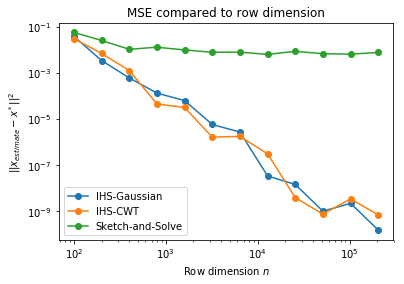

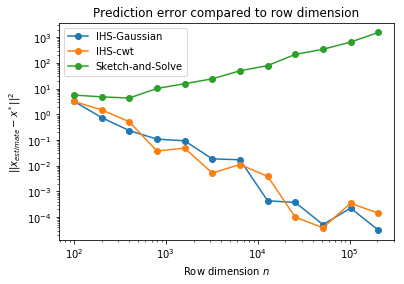

In [15]:
test_all_methods_samples(4)

Now we will test the log-error to ridge solution versus iterations with various sketch sizes in both Gaussian and CountSketch regimes.

In [16]:
X, y, x_star = generate_data(nsamples=6000, nfeatures=200)
n,d = X.shape
gamma_vals = [4,7,10]
number_iterations = range(0,40, 5)
regulariser = 1.0

# setup independent variables
iter_gauss_vs_ridge_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}
iter_cwt_vs_ridge_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

In [17]:
# Ridge estimator
ridge = Ridge(alpha=regulariser)
ridge.fit(X,y)
x_rr = ridge.coef_

for gamma in gamma_vals:
    sketch_size = int(gamma*d)
    for ii in range(len(number_iterations)):
        print("Testing gamma: {}, num_iterations: {}".format(gamma,ii))
        iter_num = number_iterations[ii]
    
    
        # x_t is IHS output after iter_num iterations
        x_t = iterative_hessian_ridge(data=X,targets=y,
                                    sketch_size=sketch_size,
                                      alpha=regulariser,
                                      num_iters=iter_num)
        x_cwt = iterative_hessian_cwt_ridge(data=X,targets=y,
                                    sketch_size=sketch_size,
                                      alpha=regulariser,
                                      num_iters=iter_num)
    
        iter_gauss_vs_ridge_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_rr))
        iter_cwt_vs_ridge_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_cwt-x_rr))
        


Testing gamma: 4, num_iterations: 0
Testing gamma: 4, num_iterations: 1
Testing gamma: 4, num_iterations: 2
Testing gamma: 4, num_iterations: 3
Testing gamma: 4, num_iterations: 4
Testing gamma: 4, num_iterations: 5
Testing gamma: 4, num_iterations: 6
Testing gamma: 4, num_iterations: 7
Testing gamma: 7, num_iterations: 0
Testing gamma: 7, num_iterations: 1
Testing gamma: 7, num_iterations: 2
Testing gamma: 7, num_iterations: 3
Testing gamma: 7, num_iterations: 4
Testing gamma: 7, num_iterations: 5
Testing gamma: 7, num_iterations: 6
Testing gamma: 7, num_iterations: 7
Testing gamma: 10, num_iterations: 0
Testing gamma: 10, num_iterations: 1
Testing gamma: 10, num_iterations: 2
Testing gamma: 10, num_iterations: 3
Testing gamma: 10, num_iterations: 4
Testing gamma: 10, num_iterations: 5
Testing gamma: 10, num_iterations: 6
Testing gamma: 10, num_iterations: 7


Text(0.5,1,'Error to least-squares solution vs iteration - CountSketch')

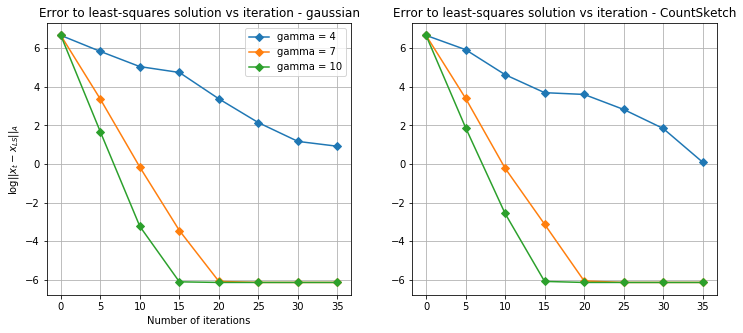

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(12,5),
                       sharey=False, sharex=True)

for gamma in gamma_vals:
    ax[0].plot(number_iterations, np.log(iter_gauss_vs_ridge_errors[gamma]),
            '-D', label="gamma = {}".format(gamma))
    ax[0].grid(True)
    ax[1].plot(number_iterations, np.log(iter_cwt_vs_ridge_errors[gamma]),
            '-D', label="gamma = {}".format(gamma))
    ax[1].grid(True)
ax[0].legend()
ax[0].set_xlabel("Number of iterations")
ax[0].set_ylabel("$\log ||x_t - x_{LS} ||_A$")
ax[0].set_title('Error to least-squares solution vs iteration - gaussian')
ax[1].set_title('Error to least-squares solution vs iteration - CountSketch')

## Future Work
- LASSO using SciPy
- Dual Random Projection for kernels

## Testing the scipy optimize code with constraints

Change from matrix form to constraint form.  

From documentation: "Equality constraint means that the constraint function result is to be zero whereas inequality means that it is to be non-negative." 

In order to enforce $\sum_i |w_i| \le t$ we need to code something like $0 \le t - \sum_i |w_i|$

In [36]:
def lasso_function(x, data, target, sketch, alpha, offset, step_size):
    A = data
    #S = np.eye(A.shape[0])
    S = sketch
    #print(S.shape)
    #print(A.shape)
    y = target
    xt = np.ravel(offset)

    #print(xt.shape)
    #print((S@y).shape)
    #print((S@A@(x-xt)).shape)
    
    norm_val = norm(S@A@(x-xt))**2 #+ alpha*norm(x-xt)**2
    inner_prod = (y.T@A - xt@(A.T@A) - alpha*xt)@(x-xt)
        #A.T@(y - A@xt).T@A@(x-xt) - alpha*xt.T@(x-xt)
    taylor_approximation = norm_val + inner_prod
    closeness_term = (0.5*1/step_size)*norm(x-xt)
    non_differentiable = norm(x-xt,1)
    
    return taylor_approximation + closeness_term + non_differentiable

def iterative_hessian_lasso(data, targets, sketch_size, alpha, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        x0 = np.zeros((X.shape[0],1))
        xt = np.zeros((d,1))
        x_new = np.zeros((d,1))
        for it in range(20):
            result = minimize(lasso_function, x0=x_new,args=(X,y,S,alpha,x_new,1),
                             method='L-BFGS-B',
                             )
        #    print(result)
            x_new = result.x
        
        #x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [32]:
X, y, _ = generate_data(1000, 5)

In [37]:
x_lasso = iterative_hessian_lasso(X,y,1000,1,5)

In [38]:
x_lasso

array([ -454004.04019009, -1062742.75173165,    29549.9014108 ,
        -405878.95822263,   154768.37202027])

In [35]:
lasso = Lasso(alpha=1.0)
lasso.fit(X,y)
coef_ridge = lasso.coef_
coef_ridge

array([ 88.99555036,  98.24593125,   2.72564066,  46.47223468,  11.37868953])